In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
print("pytorch ver . ",torch.__version__)
print("Is CUDA available?",torch.cuda.is_available())
import torch.nn as nn
import torch.optim as optim

pytorch ver .  1.11.0+cu113
Is CUDA available? True


/home/luhung3080/miniconda3/envs/chou/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read data

In [2]:
data=pd.read_csv('/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/data_final.csv')

# Generate X Y 

In [3]:
x1=np.zeros([604,1704])
x2=np.zeros([604,5112])

#x1 (0th~1703th column as x)
for i in range (0,604):
    for j in range (0,71):
        a=np.array(data['pm25_obs'][5112*i+72*j:5112*i+72*j+24])
        for k in range (0,24):
            x1[i][j*24+k]=a[k]

#x2 (1704th~8519th column as x)
for i in range (1,604):
    b=np.array(data['pm25_cal'][5112*i:5112*i+5112])
    for j in range(0,5112):
        x2[i-1][j]=b[j]
        
print(np.shape(x1))
print(np.shape(x2))

(604, 1704)
(604, 5112)


In [4]:
x1Restruct_Fun=x1
x2Restruct_Fun=x2
print(np.shape(x1Restruct_Fun))
print(np.shape(x2Restruct_Fun))

(604, 1704)
(604, 5112)


In [5]:
YRestruct_Fun=np.zeros([601,5112])
for j in range (0,71):
    for i in range(0,601):
        YRestruct_Fun[i][72*j:72*j+24]=x1Restruct_Fun[1+i][24*j:24*j+24]
        YRestruct_Fun[i][72*j+24:72*j+48]=x1Restruct_Fun[1+i+1][24*j:24*j+24]
        YRestruct_Fun[i][72*j+48:72*j+72]=x1Restruct_Fun[1+i+2][24*j:24*j+24]
print(np.shape(YRestruct_Fun))

(601, 5112)


In [6]:
XRestruct_Fun=np.zeros([601,6816])
for i in range (0,601):
    for j in range (0,1704):
        XRestruct_Fun[i][j]=x1Restruct_Fun[i][j]
    for j in range (1704,6816):
        XRestruct_Fun[i][j]=x2Restruct_Fun[i][j-1704]
print(np.shape(XRestruct_Fun))

(601, 6816)


In [7]:
Xhat=XRestruct_Fun
Yhat=YRestruct_Fun
Xhat_train = np.zeros([540,6816])
Yhat_train = np.zeros([540,5112])
Xhat_test = np.zeros([61,6816])
Yhat_test = np.zeros([61,5112])
for i in range (0,540):
    for j in range (0,6816):
        Xhat_train[i][j] = Xhat[i][j]
    for j in range (0,5112):
        Yhat_train[i][j] = Yhat[i][j]
for i in range (540,601):
    for j in range (0,6816):
        Xhat_test[i-544][j] = Xhat[i][j]
    for j in range (0,5112):     
        Yhat_test[i-544][j] = Yhat[i][j]
        
print('Xhat_train')
#print(Xhat_train)
print(np.shape(Xhat_train))
print('Yhat_train')
#print(Yhat_train)
print(np.shape(Yhat_train))
print('Xhat_test')
#print(Xhat_test)
print(np.shape(Xhat_test))
print('Yhat_test')
#print(Yhat_test)
print(np.shape(Yhat_test))

Xhat_train
(540, 6816)
Yhat_train
(540, 5112)
Xhat_test
(61, 6816)
Yhat_test
(61, 5112)


# Modeling

In [8]:
x = Xhat_train
y = Yhat_train
xt = Xhat_test
yt = Yhat_test

In [9]:
def model (x,b0,b1):
    y = b0 +  torch.mm(x , b1)
    return y

In [ ]:
features = torch.from_numpy(x)
targets = torch.from_numpy(y)
x_test = torch.from_numpy(xt)
y_test = torch.from_numpy(yt)

beta0 = torch.ones(5112 , requires_grad = True)
beta1 = torch.ones([6816, 5112], requires_grad = True)

rate = 1e-3
optimizer = optim.Adam([beta0 , beta1], lr=rate)

epo = 2001
loss = nn.L1Loss()
train_error = np.zeros(epo)
test_error = np.zeros(epo)


for epoch in range (epo):
    yhats_train = model(features.float() , beta0 , beta1)
    train_loss = loss(targets.float() , yhats_train)
    train_error[epoch] = train_loss

    optimizer.zero_grad()
    train_loss.backward() 
    optimizer.step()    

    yhats_test = model(x_test.float(), beta0, beta1) 
    r = torch.abs(yhats_test - y_test)
    test_loss = torch.nanmean(r)
    test_error[epoch] = test_loss

    if epoch <= 10 or epoch % 10 == 0:
        print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                    f" Testing loss {test_loss.item():.4f}")
    else :
        if epoch >= epo-10 :
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                        f" Testing loss {test_loss.item():.4f}")

# Result

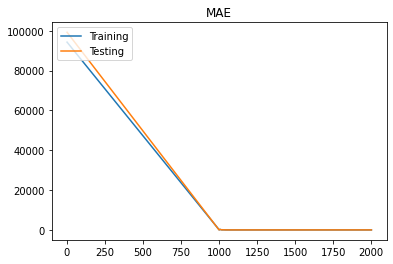

In [11]:
fig1 = plt.figure(1)
x=np.linspace(1,epo,epo)
plt.plot(x,train_error, label = 'Training')
plt.plot(x,test_error, label ='Testing')
plt.legend(loc = 2)
plt.title('MAE')

plt.show()

In [12]:
print(np.min(test_error))

4.976552407273451
